In [30]:
import os
import re
autores = ['Calderaro', 'Fonteveccia', 'Pagni', 'VanderKooy', 'Verbitsky']
textos = []
for autor in autores:
    for filename in os.listdir(f'data/autores/{autor}'):
        with open(f'data/autores/{autor}/{filename}', 'r', encoding='latin-1') as f:
            textos.append((autor, f.read()))

            
def sanitize(s):
    # Sacar todo lo que no es alfanumerico y pasar a minusculas, pero dejando los puntos
    s = s.lower()
    s = re.sub(r'\.', 'X', s)
    s = re.sub(r'\W+', ' ', s)
    s = re.sub('X', '.', s)
    return s

textos = [(a, sanitize(t)) for (a,t) in textos]

## Color bar plot

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def plot_color_bars(cs, labels, values):
    data = []
    for idx, l in enumerate(labels):
        cls = np.array(cs[l])
        data.append([(cls == v).sum() for v in values])

    df2 = pd.DataFrame(data, columns=values)
    ax = df2.plot.barh(stacked=True);
    ax.set_yticklabels(labels)
    plt.show()

## Feature extraction

In [32]:
import numpy as np
from collections import Counter

def count_words(s):
    return len(s.split(" "))

def count_patterns(s, patterns):
    s = f' {s} '
    return sum([s.count(f' {p} ') for p in patterns])
    

# Cantidad promedio de palabras por oración relativa a la cantidad de palabras de todo el texto.
def palabras_por_oracion(t):
    oraciones = t.split('.')
    return np.mean(list(map(count_words, oraciones))) / count_words(t)

# Suma de las frecuencias relativas de las cinco palabras más repetidas
def frecuencias_relativas(t, n = 5):
    c = Counter(t.split(' '))
    total = count_words(t)
    return sum(map(lambda x: x[1]/total, c.most_common(n)))
    

# Cantidad de palabras diferentes en el texto, relativa a la cantidad total de palabras
def palabras_diferentes(t):
    palabras = t.split(' ')
    return len(set(palabras))/len(palabras)
   

def relative_patterns(patterns):
    return lambda s: count_patterns(s, patterns) / count_words(s)

# Cantidad de Conjunciones subordinantes
subordinantes = ["porque","pues","ya que","puesto que","a causa de","debido a","luego","conque","así que", "si","para que","a fin de que","como","que","aunque","aun cuando","si bien"]
conjunciones_subordinantes = relative_patterns(subordinantes)

# Cantidad de Conjunciones coordinantes
coordinantes = ["ni", "y", "o", "o bien", "pero", "aunque", "no obstante", "sin embargo", "sino", "por el contrario"]
conjunciones_coordinantes = relative_patterns(coordinantes)

# Cantidad de articulos determinados
determinados = ["la", "el", "los", "las"]
articulos_determinados = relative_patterns(determinados)

# Cantidad de articulos indeterminados
indeterminados = ["un", "una", "unos", "unas"]
articulos_indeterminados = relative_patterns(indeterminados)

# Cantidad de palabras terminadas en "mente"
def terminan_mente(t):
    return len(list(filter(lambda x: re.match(r'.+mente', x), t.split(' ')))) / count_words(t)

## Transformar textos en atributos

In [4]:
# Seleccionamos los atributos que queremos sacar
# aca se pueden comentar lo qeu no nos interesan
features_selected = [palabras_por_oracion, 
                     frecuencias_relativas,
                     palabras_diferentes,
                     conjunciones_subordinantes,
                     conjunciones_coordinantes,
                     articulos_determinados,
                     articulos_indeterminados,
                     terminan_mente
                    ]

def transform(t):
    return [f(t) for f in features_selected]

    
textos_transformed = [(a, transform(t)) for (a,t) in textos]

# X tiene la representacion de los textos, y tiene los autores
X = [p[1] for p in textos_transformed]
y = [p[0] for p in textos_transformed]

## K-Medias

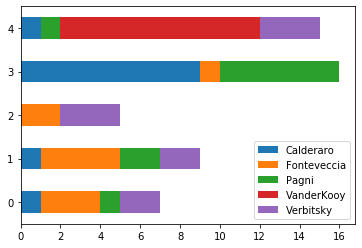

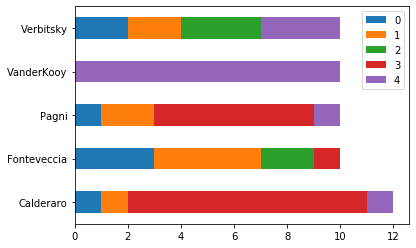

Adjusted Rand Score:  0.28314762937843585


In [45]:
from kmeans import kmeans
from collections import defaultdict
import pprint

clustered = kmeans(textos_transformed, 5, vector_sel = lambda x: x[1])

groups = defaultdict(list)
classifications = defaultdict(list)
for c in clustered:
    groups[c[1]].append(c[0][0])
    classifications[c[0][0]].append(c[1])

plot_color_bars(groups, [0, 1, 2, 3, 4], ['Calderaro', 'Fonteveccia', 'Pagni', 'VanderKooy', 'Verbitsky'])
plot_color_bars(classifications, ['Calderaro', 'Fonteveccia', 'Pagni', 'VanderKooy', 'Verbitsky'], [0, 1, 2, 3, 4])

labels_true = y
labels_pred = [c[1] for c in clustered]
ars = metrics.adjusted_rand_score(labels_true, labels_pred)
print('Adjusted Rand Score: ', ars)

## Kohonen

In [26]:
from kohonen import Kohonen, neighborhood_linear, linear_decay

kc = Kohonen()

kc.fit(X, 
       dim = 4, 
       epochs = 1000, 
       alpha = linear_decay(0.1, 1000), 
       neighborhood = neighborhood_linear(3, 1000))

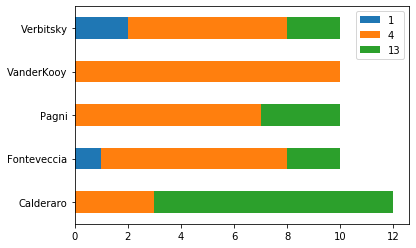

In [27]:
classes = [kc.predict(x) for x in X]

classifications = defaultdict(list)
all_values = []
for c in zip(y, classes):
    classifications[c[0]].append(c[1])
    all_values.append(c[1])

plot_color_bars(classifications, ['Calderaro', 'Fonteveccia', 'Pagni', 'VanderKooy', 'Verbitsky'], np.unique(all_values))

## Agrupamiento Jerárquico

In [28]:
from hierarchy import HierarchicalClassifier

hc = HierarchicalClassifier(distance_measure = 'centroid')
hc.fit(X)

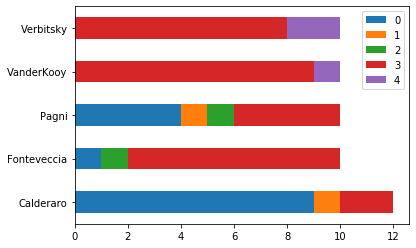

Adjusted Rand Score:  0.1266538214515093


In [46]:
classes = hc.predict(X, 5)

classifications = defaultdict(list)
for c in zip(y, classes):
    classifications[c[0]].append(c[1])
    
authors = ['Calderaro', 'Fonteveccia', 'Pagni', 'VanderKooy', 'Verbitsky']
values = [0, 1, 2, 3, 4]

plot_color_bars(classifications, authors, values)
labels_true = y
labels_pred = classes
ars = metrics.adjusted_rand_score(labels_true, labels_pred)
print('Adjusted Rand Score: ', ars)